In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from auxiliary.data_clean2 import *
import matplotlib.pyplot as plt


In [2]:
# Read Data 
data = pd.read_csv('GSMArena_dataset_2020.csv', index_col=0)
data_features = data[all_features]

# Clean data
data_features = clean_data(data_features)

# Drop features
df = data_features
# drop # 1st line: key_index and 7th line: misc_price 
temp1 = df.values[:,1:8]
temp2 = df.values[:,9:]
td = np.concatenate((temp1,temp2),axis=1)

C:\Users\chengze\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (67,68,72,77,79,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\chengze\Desktop\UNSW\COMP9417\assignment\Great-Group-ML-master\ml_algorithms\auxiliary\data_clean2.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = s.str.extract(r"(\d+)")
C:\Users\chengze\Desktop\UNSW\COMP9417\assignment\Great-Group-ML-master\ml_algorithms\auxiliary\data_clean2.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [3]:
# Divide Y(price) into catagories
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from feature_selection import y_classify_five, y_classify
from sklearn.model_selection import train_test_split

mX = td
mY = df["misc_price"].astype("int").values.reshape(-1,1)

# Divide price into 3 catagories bt function y_classify()
tempList = []
mY = mY.reshape(-1)
for item in mY:
    tempList.append(y_classify(item))
mY = tempList

# Do standard scaler for data in X
sc = StandardScaler()
sc.fit(mX)
mX = sc.transform(mX)

# Run Onehot encode for Y
mY = np.array(mY).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(mY)
mY = enc.transform(mY).toarray()

# Split data into train, test
X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=.2, random_state=0)
Y_train = np.array(Y_train) #.reshape(-1,1)
Y_test = np.array(Y_test) #.reshape(-1,1)


In [4]:
# Reference: Implementation, COMP9417 Week 6 Tutorial5, Lab6_NeuralLearning_Qs.ipynb
class NeuralNetwork(object):
    def __init__(self, learning_rate=0.1, epochs=1000, batch_size=None, neural_numbers=[10]):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.neural_numbers=neural_numbers
        self.layers=len(self.neural_numbers)+1
        np.random.seed(77)

    def fit(self,X,y):
        self.X, self.y = X,y
        self.initial_weight()
        self.backpropagate(X,y)
    
    def forward(self,X):
        output_list = []
        input_x = X

        for layer in range(self.layers):

            cur_weight = self.weight_list[layer]
            cur_bias = self.bias_list[layer]
            # Calculate the output for current layer
            output = self.neuron_output(cur_weight,input_x,cur_bias)
            # The current output will be the input for the next layer.
            input_x =  output

            output_list.append(output)
        return output_list

    def backpropagate(self,train_x,train_y):
        acc_list=[]
        for iteration in range(self.epochs):
            if self.batch_size:
                n=train_x.shape[0]
                
                # Sample batch_size number of sample for n samples
                sample_index=np.random.choice(n, self.batch_size, replace=False)
                x=train_x[sample_index,:]
                y=train_y[sample_index,:]
            else:
                x=train_x
                y=train_y

            output_list=self.forward(x)
            y_pred=output_list.pop()
            
            # Record the accuracy every 5 iteration.
            if iteration%5==0:
                acc=self.accuracy(self.softmax(y),self.softmax(y_pred))
                acc_list.append(acc)
            
            # Print the learning processing
            if iteration%100==0:
                print("Iteration: ", iteration, "\tValidated accuracy: ", self.accuracy(self.softmax(y),self.softmax(y_pred)))

            loss_last=y-y_pred

            output=y_pred

            for layer in range(self.layers-1,-1,-1):
                if layer!=0:
                    input_last=output_list.pop()
                else:
                    input_last=x

                if layer==self.layers-1:
                    loss,dw,db=self.der_last_layer(loss_last,output,input_last)
                else:
                    weight=self.weight_list[layer+1]
                    loss,dw,db=self.der_hidden_layer(loss_last,output,input_last,weight)

                output=input_last
                self.weight_list[layer] += dw*self.learning_rate
                self.bias_list[layer] += db*self.learning_rate
                loss_last=loss
        self.acc_list=acc_list

    def predict(self,X):
        output_list = self.forward(X)
        pred_y = self.softmax(output_list[-1])
        return pred_y

    def accuracy(self, pred, y_test):
        assert len(pred) == len(y_test)
        true_pred=np.where(pred==y_test)
        if true_pred:
            true_n = true_pred[0].shape[0]
            return true_n/len(pred)
        else:
            return 0

    def initial_weight(self):
        if self.X is not None and self.y is not None:
            x=self.X
            y=self.y
            input_dim = x.shape[1]
            output_dim = y.shape[1]

            number_NN = self.neural_numbers+[output_dim]

            weight_list,bias_list = [],[]
            last_neural_number = input_dim     

            for cur_neural_number in number_NN:
                # The dimension of weight matrix is last neural number * current neural number
                weights = np.random.randn(last_neural_number, cur_neural_number)
                # The number of dimension for bias is 1 and the number of current neural
                bias = np.zeros((1, cur_neural_number))

                last_neural_number=cur_neural_number

                weight_list.append(weights)
                bias_list.append(bias)

            self.weight_list=weight_list
            self.bias_list=bias_list

    # Classical sigmoid activation functions are used in every layer in this network
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Derivation of the sigmoid activation function
    def sigmoid_der(self, x):
        return (1 - x) * x

    # Calculate the output for this layer
    def neuron_output(self,w,x,b):
        wx=np.dot(x, w)
        return self.sigmoid( wx + b)

    def der_last_layer(self,loss_last,output,input_x):
        sigmoid_der=self.sigmoid_der(output)
        loss = sigmoid_der*loss_last
        dW = np.dot(input_x.T, loss)
        db = np.sum(loss, axis=0, keepdims=True)
        return loss,dW,db

    def der_hidden_layer(self,loss_last,output,input_x,weight):
        loss = self.sigmoid_der(output) * np.dot(loss_last,weight.T)
        db = np.sum(loss, axis=0, keepdims=True)
        dW = np.dot(input_x.T, loss)
        return loss,dW,db

    def softmax(self,y):
        return np.argmax(y,axis=1)

In [5]:
Learning_rate=0.05
nn=NeuralNetwork(learning_rate=Learning_rate, neural_numbers=[1000])
print("Learning by Neural Network...")
nn.fit(X_train,Y_train)
print("Finished!")

Learning by Neural Network...
Iteration:  0 	Validated accuracy:  0.25483091787439616
Iteration:  100 	Validated accuracy:  0.7185990338164251
Iteration:  200 	Validated accuracy:  0.7294685990338164
Iteration:  300 	Validated accuracy:  0.7318840579710145
Iteration:  400 	Validated accuracy:  0.7355072463768116
Iteration:  500 	Validated accuracy:  0.7415458937198067
Iteration:  600 	Validated accuracy:  0.7403381642512077
Iteration:  700 	Validated accuracy:  0.7451690821256038
Iteration:  800 	Validated accuracy:  0.7282608695652174
Iteration:  900 	Validated accuracy:  0.75
Finished!


In [6]:
pred_y = nn.predict(X_test).reshape(-1)
Y_test = np.argmax(Y_test, axis = 1)
#print(Y_test)
#print(np.argmax(pred_y, axis = 1))
#print(pred_y)

correctTF = (Y_test==pred_y)
correctNum = sum(correctTF==True)
accuracy = correctNum/len(Y_test)
#accuracy = nn.accuracy(pred_y, Y_test)
print("-------------------------")
print("Test accuracy", str(accuracy))
print("-------------------------")
#print(Y_test-pred_y)

-------------------------
Test accuracy 0.6811594202898551
-------------------------


Iteration:  0 	Validated accuracy:  0.4214975845410628
Iteration:  100 	Validated accuracy:  0.6944444444444444
Iteration:  200 	Validated accuracy:  0.7403381642512077
Iteration:  300 	Validated accuracy:  0.7185990338164251
Iteration:  400 	Validated accuracy:  0.7391304347826086
Iteration:  500 	Validated accuracy:  0.751207729468599
Iteration:  600 	Validated accuracy:  0.7657004830917874
Iteration:  700 	Validated accuracy:  0.7705314009661836
Iteration:  800 	Validated accuracy:  0.7608695652173914
Iteration:  900 	Validated accuracy:  0.7644927536231884
Iteration:  0 	Validated accuracy:  0.4214975845410628
Iteration:  100 	Validated accuracy:  0.5410628019323671
Iteration:  200 	Validated accuracy:  0.5471014492753623
Iteration:  300 	Validated accuracy:  0.5434782608695652
Iteration:  400 	Validated accuracy:  0.4963768115942029
Iteration:  500 	Validated accuracy:  0.4528985507246377
Iteration:  600 	Validated accuracy:  0.4528985507246377
Iteration:  700 	Validated accuracy:

C:\Users\chengze\anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: overflow encountered in exp


 500 	Validated accuracy:  0.44323671497584544
Iteration:  600 	Validated accuracy:  0.44323671497584544
Iteration:  700 	Validated accuracy:  0.44323671497584544
Iteration:  800 	Validated accuracy:  0.44323671497584544
Iteration:  900 	Validated accuracy:  0.44323671497584544


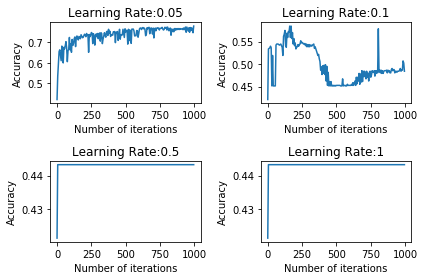

In [7]:
# Reference: Implementation, COMP9417 Week 6 Tutorial5, Lab6_NeuralLearning_Qs.ipynb
def test_LearnRate(Learning_rate,inputs,targets):
    nn=NeuralNetwork(learning_rate=Learning_rate)
    nn.fit(inputs,targets)
    acc_array=np.array(nn.acc_list)
    plt.plot(np.arange(acc_array.shape[0])*5,acc_array)
    plt.title("Learning Rate:{}".format(Learning_rate))
    plt.ylabel("Accuracy")
    plt.xlabel("Number of iterations")


plt.figure()
plt.subplot(2,2,1)
Learning_rate=0.05
test_LearnRate(Learning_rate,X_train,Y_train)

plt.subplot(2,2,2)
Learning_rate=0.1
test_LearnRate(Learning_rate,X_train,Y_train)

plt.subplot(2,2,3)
Learning_rate=0.5
test_LearnRate(Learning_rate,X_train,Y_train)

plt.subplot(2,2,4)
Learning_rate=1
test_LearnRate(Learning_rate,X_train,Y_train)
plt.tight_layout()
plt.show()